In [1]:
# pip install CensusData

In [2]:
import pandas as pd
import censusdata
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import glob

%matplotlib inline
%config InlineBackend.figure_format ='retina'

In [3]:
sharedFolder = '/work/group/egodat/reu23_clark/'
dataFolder = sharedFolder + 'data/'

In [4]:
statesShp = geopandas.read_file(dataFolder + "/cb_2018_us_state_500k.zip").to_crs(3857)
statesShp = statesShp[['GEOID', 'STUSPS', 'NAME', 'geometry']]

def plotUS():
    ax = statesShp.plot(figsize=(20, 10))
    ax.axis('equal')
    plt.xlim(-1.5e7, -0.7e7)
    plt.ylim(2.5e6, 7e6)
    return ax

In [5]:
xwalk = pd.read_pickle(dataFolder + "/xwalk_data_combined.pkl")
xwalk

,ctyname,bgrp,cbsa
0,"Rockingham County, NH",330150710012,14460
1,"Merrimack County, NH",330130380002,18180
2,"Merrimack County, NH",330130415001,18180
3,"Hillsborough County, NH",330110225011,31700
4,"Hillsborough County, NH",330110103022,31700
...,...,...,...
57404,"Elko County, NV",320079515003,21220
57405,"Elko County, NV",320079515003,21220
57406,"Elko County, NV",320079517002,21220
57407,"Elko County, NV",320079502001,21220


In [6]:
#Extract block group code
xwalk['fips'] = (xwalk['bgrp'] / 10**7).astype(int)
fipsToCbsa = xwalk.groupby('fips').first()['cbsa']
fipsToCbsa = dict(zip(fipsToCbsa.index, fipsToCbsa.values)) #Dict is faster for lookup

In [7]:
# https://api.census.gov/data/2021/acs/acs5/variables.html

demographic_variables_dict = {
    'B01003_001E': 'Total_Population',
    'B01001_002E': 'Total_Male_Pop',
    'B01001_026E': 'Total_Female_Pop',
    'B01002_001E': 'Median_Age',
    'B01002_002E': 'M_Median_Age',
    'B01002_003E': 'F_Median_Age',
    'B02001_002E': 'Race_white',
    'B02001_003E': 'Race_black',
    'B02001_004E': 'Race_Am_Indian',
    'B02001_005E': 'Race_Asian',
    'B02001_006E': 'Race_Pac_Isl',
    'B20004_001E': 'Median_Income',
    'B20004_002E': 'Less_High',
    'B20004_003E': 'High_Equiv',
    'B20004_004E': 'College_Assoc_Equiv',
    'B20004_005E': 'Bachelors',
    'B20004_006E': 'Grad_Prof',
    
    #Median Earnings by Occupation
    'B24031_002E': 'Ag_For_Fish_Hunt_Mine',
    #'B24031_003E':'Ag_For_Fish_Hunt'
    #'B24031_004E':'Mine_Fish'
    'B24031_005E': 'Construction',
    'B24031_006E': 'Manufacturing',
    'B24031_007E': 'Wholesale',
    'B24031_008E': 'Retail',
    'B24031_009E': 'Trans_Ware_Util',
    #'B24031_010E':'Trans_Ware'
    #'B24031_011E':'Util'
    'B24031_012E': 'Information',
    'B24031_013E': 'Fin_Insur_Real',
    'B24031_014E': 'Fin_Insur',
    'B24031_015E': 'Real_Rental',
    #'B24031_016E':'Prof_Sci_Mngmt'
    'B24031_017E': 'Prof_Sci_Tech',
    'B24031_018E': 'Mngmt_Enter',
    'B24031_019E': 'Admin_WstMngmt',
    #'B24031_020E':'Ed_Health_Social'
    'B24031_021E': 'Ed_Servc',
    'B24031_022E': 'Hlthcr_Social',
    #'B24031_023E':'Arts_Entr_Rec_Fod'
    'B24031_024E': 'Arts_Entr_Rec',
    'B24031_025E': 'Accom_Food_Srvc',
    'B24031_026E': 'Other_Servc',
    'B24031_027E': 'Public_admin',
    
    
    #Civilians by Detailed Occupation
    'B24114_001E': 'Num_Total_Worker',
    'B24114_064E': 'Num_Comp_Info_Res',
    'B24114_068E': 'Num_Soft_Dev',
    'B24114_065E': 'Num_Comp_Sys_Analyst',
    'B24114_066E': 'Num_Info_Sec_Analyst',
    'B24114_067E': 'Num_Comp_Programmer',
    'B24114_069E': 'Num_Soft_Qual',
    'B24114_070E': 'Num_Web_Dev',
    
    
    #OCCUPATION BY MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS) FOR THE FULL-TIME, YEAR-ROUND CIVILIAN EMPLOYED POPULATION 16 YEARS AND OVER
    'B24021_001E': 'Sal_Avg_Occ',
    'B24021_006E': 'Avg_Comp_EngSci',
    'B24012_003E': 'Avg_Mngmt_Bus_Fin'
    

}

aggType = {
    'Total_Population': 'sum',
    'Total_Male_Pop': 'sum',
    'Total_Female_Pop': 'sum',
    'Median_Age': 'mean',
    'M_Median_Age': 'mean',
    'F_Median_Age': 'mean',
    'Race_white': 'sum',
    'Race_black': 'sum',
    'Race_Am_Indian': 'sum',
    'Race_Asian': 'sum',
    'Race_Pac_Isl': 'sum',
    'Median_Income': 'mean',
    'Less_High': 'sum',
    'High_Equiv': 'sum',
    'College_Assoc_Equiv': 'sum',
    'Bachelors': 'sum',
    'Grad_Prof': 'sum',
    
    #Median Earnings by Occupation
    'Ag_For_Fish_Hunt_Mine': 'mean',
    #'B24031_003E':'Ag_For_Fish_Hunt'
    #'B24031_004E':'Mine_Fish'
    'Construction': 'mean',
    'Manufacturing': 'mean',
    'Wholesale': 'mean',
    'Retail': 'mean',
    'Trans_Ware_Util': 'mean',
    #'B24031_010E':'Trans_Ware'
    #'B24031_011E':'Util'
    'Information': 'mean',
    'Fin_Insur_Real': 'mean',
    'Fin_Insur': 'mean',
    'Real_Rental': 'mean',
    #'B24031_016E':'Prof_Sci_Mngmt'
    'Prof_Sci_Tech': 'mean',
    'Mngmt_Enter': 'mean',
    'Admin_WstMngmt': 'mean',
    #'B24031_020E':'Ed_Health_Social'
    'Ed_Servc': 'mean',
    'Hlthcr_Social': 'mean',
    #'B24031_023E':'Arts_Entr_Rec_Fod'
    'Arts_Entr_Rec': 'mean',
    'Accom_Food_Srvc': 'mean',
    'Other_Servc': 'mean',
    'Public_admin': 'mean',
    
    
    #Civilians by Detailed Occupation
    'Num_Total_Worker': 'sum',
    'Num_Comp_Info_Res': 'sum',
    'Num_Soft_Dev': 'sum',
    'Num_Comp_Sys_Analyst': 'sum',
    'Num_Info_Sec_Analyst': 'sum',
    'Num_Comp_Programmer': 'sum',
    'Num_Soft_Qual': 'sum',
    'Num_Web_Dev': 'sum',
    
    
    #OCCUPATION BY MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS) FOR THE FULL-TIME, YEAR-ROUND CIVILIAN EMPLOYED POPULATION 16 YEARS AND OVER
    'Sal_Avg_Occ': 'mean',
    'Avg_Comp_EngSci': 'mean',
    'Avg_Mngmt_Bus_Fin': 'mean'
}


years = range(2018, 2021+1)
dfs = []
dataByCbsa = {}

for year in years:
    df = censusdata.download('acs5', year, censusdata.censusgeo([('county', '*')]), 
                                     # to get variable, add code to this list
                                     list(demographic_variables_dict.keys()))
    df['year'] = year
    dfs.append(df)
data = pd.concat(dfs)

#     data[year].rename(columns=demographic_variables_dict, inplace=True)
#     data[year] = data[year].reset_index().rename(columns = {"index":"FIPS"})
#     data[year]["FIPS"] = data[year]["FIPS"].apply(lambda x: x.params()[0][1] + x.params()[1][1])
#     data[year]['FIPS'] = data[year]['FIPS'].astype(float)
#     data[year][data[year] < 0] = float('nan')
#     data[year]['CBSA'] = data[year]['FIPS'].apply(lambda c: fipsToCbsa.get(c, 99999))

#     data[year] = data[year].groupby(by='CBSA').agg(aggType)

# data = pd.concat(data.values(), keys=data.keys())
data

,B01003_001E,B01001_002E,B01001_026E,B01002_001E,B01002_002E,B01002_003E,B02001_002E,B02001_003E,B02001_004E,B02001_005E,...,B24114_068E,B24114_065E,B24114_066E,B24114_067E,B24114_069E,B24114_070E,B24021_001E,B24021_006E,B24012_003E,year
"Mineral County, Montana: Summary level: 050, state:30> county:061",4211,2135,2076,52.6,53.7,51.3,3926,3,107,61,...,None,None,None,None,None,None,31987.0,67981.0,42604.0,2018
"Petroleum County, Montana: Summary level: 050, state:30> county:069",432,229,203,52.1,52.4,51.8,424,0,0,8,...,None,None,None,None,None,None,40769.0,-666666666.0,38571.0,2018
"Powell County, Montana: Summary level: 050, state:30> county:077",6861,4310,2551,45.3,42.8,49.9,6235,24,301,34,...,None,None,None,None,None,None,38523.0,53750.0,44554.0,2018
"Sanders County, Montana: Summary level: 050, state:30> county:089",11521,5935,5586,53.2,52.9,53.5,10630,19,410,59,...,None,None,None,None,None,None,31780.0,57361.0,35703.0,2018
"Wibaux County, Montana: Summary level: 050, state:30> county:109",1175,561,614,46.0,50.5,45.3,1167,0,4,4,...,None,None,None,None,None,None,42143.0,-666666666.0,40781.0,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Vega Baja Municipio, Puerto Rico: Summary level: 050, state:72> county:145",54544,26057,28487,43.1,41.5,44.6,30690,2409,50,9,...,None,None,None,None,None,None,24484.0,60491.0,31476.0,2021
"Vieques Municipio, Puerto Rico: Summary level: 050, state:72> county:147",8317,4239,4078,43.6,40.9,45.9,2592,629,0,14,...,None,None,None,None,None,None,16467.0,-666666666.0,-666666666.0,2021
"Villalba Municipio, Puerto Rico: Summary level: 050, state:72> county:149",22341,10796,11545,42.0,40.7,42.9,10502,1784,0,0,...,None,None,None,None,None,None,23814.0,53359.0,21250.0,2021
"Yabucoa Municipio, Puerto Rico: Summary level: 050, state:72> county:151",31047,15000,16047,44.9,43.7,46.0,3190,16119,0,11,...,None,None,None,None,None,None,22328.0,39570.0,35988.0,2021


In [8]:
# B20004_001E is for median income by educational attainment

In [9]:
# to rename variable, add to dict
 
data.rename(columns=demographic_variables_dict,
            inplace=True)

In [10]:
data = data.reset_index().rename(columns = {"index":"FIPS"})

In [11]:
data["FIPS"] = data["FIPS"].apply(lambda x: x.params()[0][1] + x.params()[1][1])

In [12]:
data['FIPS'] = data['FIPS'].astype(int)

In [13]:
data[data < 0] = float('nan')

In [14]:
data['CBSA'] = data['FIPS'].apply(lambda c: fipsToCbsa.get(c, 99999))
data

,FIPS,Total_Population,Total_Male_Pop,Total_Female_Pop,Median_Age,M_Median_Age,F_Median_Age,Race_white,Race_black,Race_Am_Indian,...,Num_Comp_Sys_Analyst,Num_Info_Sec_Analyst,Num_Comp_Programmer,Num_Soft_Qual,Num_Web_Dev,Sal_Avg_Occ,Avg_Comp_EngSci,Avg_Mngmt_Bus_Fin,year,CBSA
0,30061,4211,2135,2076,52.6,53.7,51.3,3926,3,107,...,None,None,None,None,None,31987.0,67981.0,42604.0,2018,99999
1,30069,432,229,203,52.1,52.4,51.8,424,0,0,...,None,None,None,None,None,40769.0,NaN,38571.0,2018,99999
2,30077,6861,4310,2551,45.3,42.8,49.9,6235,24,301,...,None,None,None,None,None,38523.0,53750.0,44554.0,2018,99999
3,30089,11521,5935,5586,53.2,52.9,53.5,10630,19,410,...,None,None,None,None,None,31780.0,57361.0,35703.0,2018,99999
4,30109,1175,561,614,46.0,50.5,45.3,1167,0,4,...,None,None,None,None,None,42143.0,NaN,40781.0,2018,99999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12877,72145,54544,26057,28487,43.1,41.5,44.6,30690,2409,50,...,None,None,None,None,None,24484.0,60491.0,31476.0,2021,99999
12878,72147,8317,4239,4078,43.6,40.9,45.9,2592,629,0,...,None,None,None,None,None,16467.0,NaN,NaN,2021,99999
12879,72149,22341,10796,11545,42.0,40.7,42.9,10502,1784,0,...,None,None,None,None,None,23814.0,53359.0,21250.0,2021,99999
12880,72151,31047,15000,16047,44.9,43.7,46.0,3190,16119,0,...,None,None,None,None,None,22328.0,39570.0,35988.0,2021,99999


In [15]:
dataByCbsa = data.groupby(by=['CBSA', 'year']).agg(aggType).reset_index()
dataByCbsa

,CBSA,year,Total_Population,Total_Male_Pop,Total_Female_Pop,Median_Age,M_Median_Age,F_Median_Age,Race_white,Race_black,...,Num_Comp_Info_Res,Num_Soft_Dev,Num_Comp_Sys_Analyst,Num_Info_Sec_Analyst,Num_Comp_Programmer,Num_Soft_Qual,Num_Web_Dev,Sal_Avg_Occ,Avg_Comp_EngSci,Avg_Mngmt_Bus_Fin
0,10100,2018,42780,21068,21712,40.000000,39.900000,40.400000,38820,840,...,0,0,0,0,0,0,0,42231.500000,65102.000000,60069.500000
1,10100,2019,42824,21135,21689,39.700000,39.850000,39.750000,38587,930,...,0,0,0,0,0,0,0,44380.500000,60060.500000,60004.000000
2,10100,2020,42864,21206,21658,39.250000,39.000000,39.200000,38224,913,...,0,0,0,0,0,0,0,45842.500000,58210.000000,59209.000000
3,10100,2021,42476,21155,21321,39.350000,38.700000,40.500000,37170,973,...,0,0,0,0,0,0,0,47252.500000,56491.000000,60397.500000
4,10140,2018,71967,36981,34986,43.700000,41.800000,45.500000,63343,733,...,0,0,0,0,0,0,0,42357.000000,63750.000000,66627.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3707,49820,2021,13945,6931,7014,30.900000,27.600000,32.900000,9543,0,...,0,0,0,0,0,0,0,37701.000000,125505.000000,51116.000000
3708,99999,2018,22272518,11099521,11172997,43.271522,41.953478,44.660942,18001192,2194587,...,0,0,0,0,0,0,0,38023.194928,60418.756824,51386.551449
3709,99999,2019,22178554,11052803,11125751,43.427246,42.142174,44.830580,17868699,2205230,...,0,0,0,0,0,0,0,39036.767391,61846.193041,52567.494203
3710,99999,2020,22103803,11015701,11088102,43.565243,42.268863,44.940912,17478046,2163319,...,0,0,0,0,0,0,0,40062.010138,63396.634934,53648.170891


In [16]:
dataByCbsa['Education_Pop'] = dataByCbsa['Less_High'] + dataByCbsa['High_Equiv'] + dataByCbsa['College_Assoc_Equiv'] + dataByCbsa['Bachelors'] + dataByCbsa['Grad_Prof']
dataByCbsa['Less_High_pct'] = dataByCbsa['Less_High'] / dataByCbsa['Education_Pop']
dataByCbsa['High_Equiv_pct'] = dataByCbsa['High_Equiv'] / dataByCbsa['Education_Pop']
dataByCbsa['College_Assoc_Equiv_pct'] = dataByCbsa['College_Assoc_Equiv'] / dataByCbsa['Education_Pop']
dataByCbsa['Bachelors_pct'] = dataByCbsa['Bachelors'] / dataByCbsa['Education_Pop']
dataByCbsa['Grad_Prof_pct'] = dataByCbsa['Grad_Prof'] / dataByCbsa['Education_Pop']

dataByCbsa['Bach_and_Above_pct'] = (dataByCbsa['Bachelors'] + dataByCbsa['Grad_Prof']) / dataByCbsa['Education_Pop']

dataByCbsa['Computer_Total'] = dataByCbsa['Num_Total_Worker'] + dataByCbsa['Num_Comp_Info_Res'] + dataByCbsa['Num_Soft_Dev'] + dataByCbsa['Num_Comp_Sys_Analyst'] + dataByCbsa['Num_Info_Sec_Analyst'] + dataByCbsa['Num_Comp_Programmer'] + dataByCbsa['Num_Soft_Qual'] + dataByCbsa['Num_Web_Dev']


In [17]:
dataByCbsa.to_pickle(sharedFolder + 'ACS_data.pkl')

In [18]:
gdf = pd.read_pickle(sharedFolder + 'gdf.pkl')
gdf

,CBSA,LSAD,POPESTIMATE2020,POPESTIMATE2021,POPESTIMATE2022,NAME,geometry,metro,micro,buff,inBuff,commuteBuffCount_19,workingPop_19,commutePercent_19,commuteBuffCount_20,workingPop_20,commutePercent_20,liminal
0,10180,Metropolitan Statistical Area,176866,177829,179308,"Abilene, TX","POLYGON ((-11148262.500 3832132.455, -11148249...",False,False,"POLYGON ((-11309677.340 3783320.344, -11309649...",True,7720.0,69422.0,11.120394,7146.0,66780.0,10.700809,False
1,10420,Metropolitan Statistical Area,701625,696225,697627,"Akron, OH","POLYGON ((-9060481.928 5063847.837, -9060475.5...",False,False,"POLYGON ((-9254365.317 5020257.954, -9254364.7...",True,90313.0,323548.0,27.913324,86722.0,306288.0,28.313875,False
2,10500,Metropolitan Statistical Area,148244,144922,145786,"Albany, GA","POLYGON ((-9400975.184 3713776.408, -9400980.6...",False,False,"POLYGON ((-9578772.815 3741602.731, -9578761.8...",True,4136.0,53083.0,7.791572,3686.0,50430.0,7.309141,False
3,10540,Metropolitan Statistical Area,128978,129948,130467,"Albany-Lebanon, OR","POLYGON ((-13720236.776 5551262.937, -13720393...",False,False,"POLYGON ((-13880404.968 5518947.795, -13880524...",True,6558.0,55731.0,11.767239,6390.0,54728.0,11.675925,False
4,10580,Metropolitan Statistical Area,899748,905369,904617,"Albany-Schenectady-Troy, NY","POLYGON ((-8247992.807 5305256.748, -8248085.6...",False,False,"POLYGON ((-8472736.168 5278351.957, -8472566.1...",True,25671.0,418341.0,6.136382,25289.0,390058.0,6.483395,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,49300,Micropolitan Statistical Area,116906,116129,116559,"Wooster, OH","POLYGON ((-9089178.853 5010653.858, -9088979.1...",False,False,"POLYGON ((-9303427.427 5003041.204, -9303435.5...",True,8894.0,50856.0,17.488595,8380.0,48312.0,17.345587,False
922,49380,Micropolitan Statistical Area,22207,22047,21947,"Worthington, MN","POLYGON ((-10627927.538 5441934.306, -10627791...",False,True,"POLYGON ((-10853572.863 5404615.190, -10853573...",False,0.0,10260.0,0.000000,0.0,9763.0,0.000000,False
923,49460,Micropolitan Statistical Area,23282,23334,23373,"Yankton, SD","POLYGON ((-10855702.126 5337734.746, -10853435...",False,True,"POLYGON ((-11029881.460 5334892.015, -11029883...",False,0.0,10934.0,0.000000,0.0,10222.0,0.000000,False
924,49780,Micropolitan Statistical Area,86450,86574,86113,"Zanesville, OH","POLYGON ((-9149881.580 4868949.855, -9149879.9...",False,True,"POLYGON ((-9314594.513 4866712.033, -9313763.6...",True,9978.0,34969.0,28.533844,10044.0,33194.0,30.258480,True


In [19]:
merge = pd.merge(gdf, dataByCbsa, on='CBSA', how='inner')
byYear = merge.groupby(by=['year', 'CBSA']).first()
byYear

LSAD  POPESTIMATE2020  POPESTIMATE2021  \
year CBSA                                                                     
2018 10100  Micropolitan Statistical Area            42204            42118   
     10140  Micropolitan Statistical Area            75855            76787   
     10180  Metropolitan Statistical Area           176866           177829   
     10220  Micropolitan Statistical Area            38087            38195   
     10300  Micropolitan Statistical Area            99320            99202   
...                                   ...              ...              ...   
2021 49660  Metropolitan Statistical Area           540211           537837   
     49700  Metropolitan Statistical Area           181458           182254   
     49740  Metropolitan Statistical Area           204528           206241   
     49780  Micropolitan Statistical Area            86450            86574   
     49820  Micropolitan Statistical Area            13874            13893   

            POPESTIMATE2022                               NAME  \
year CBSA                                                        
2018 10100            42037                       Aberdeen, SD   
     10140            77038                       Aberdeen, WA   
     10180           179308                        Abilene, TX   
     10220            38141                            Ada, OK   
     10300            98567                         Adrian, MI   
...                     ...                                ...   
2021 49660           535499  Youngstown-Warren-Boardman, OH-PA   
     49700           182813                      Yuba City, CA   
     49740           207842                           Yuma, AZ   
     49780            86113                     Zanesville, OH   
     49820            13849                         Zapata, TX   

                                                     geometry  metro  micro  \
year CBSA                                                                     
2018 10100  POLYGON ((-10989736.448 5659978.604, -10990063...  False   True   
     10140  POLYGON ((-13837615.681 5982098.516, -13837721...  False   True   
     10180  POLYGON ((-11148262.500 3832132.455, -11148249...  False  False   
     10220  POLYGON ((-10790478.575 4120536.368, -10790479...  False   True   
     10300  POLYGON ((-9391131.716 5145826.837, -9391131.7...  False   True   
...                                                       ...    ...    ...   
2021 49660  POLYGON ((-9017133.666 5032154.477, -9017136.6...  False  False   
     49700  POLYGON ((-13539095.212 4764106.072, -13539054...  False  False   
     49740  POLYGON ((-12775445.758 3848066.261, -12775405...  False  False   
     49780  POLYGON ((-9149881.580 4868949.855, -9149879.9...  False   True   
     49820  POLYGON ((-11063533.373 3121145.410, -11063672...  False   True   

                                                         buff  inBuff  ...  \
year CBSA                                                              ...   
2018 10100  POLYGON ((-11260422.376 5673350.686, -11260422...   False  ...   
     10140  POLYGON ((-14011312.614 6012982.039, -14012149...    True  ...   
     10180  POLYGON ((-11309677.340 3783320.344, -11309649...    True  ...   
     10220  POLYGON ((-10951414.331 4125460.111, -10951415...    True  ...   
     10300  POLYGON ((-9552071.161 5147203.615, -9552071.5...    True  ...   
...                                                       ...     ...  ...   
2021 49660  POLYGON ((-9187449.917 5005143.524, -9187448.1...    True  ...   
     49700  POLYGON ((-13735793.573 4749232.461, -13736149...    True  ...   
     49740  POLYGON ((-12941846.948 3839265.947, -12941917...    True  ...   
     49780  POLYGON ((-9314594.513 4866712.033, -9313763.6...    True  ...   
     49820  POLYGON ((-11231367.159 3143424.471, -11231876...   False  ...   

            Avg_Comp_EngSci  Avg_Mngmt_Bus_Fin  Education_Pop  Less_High_pct  \
year CBSA                  

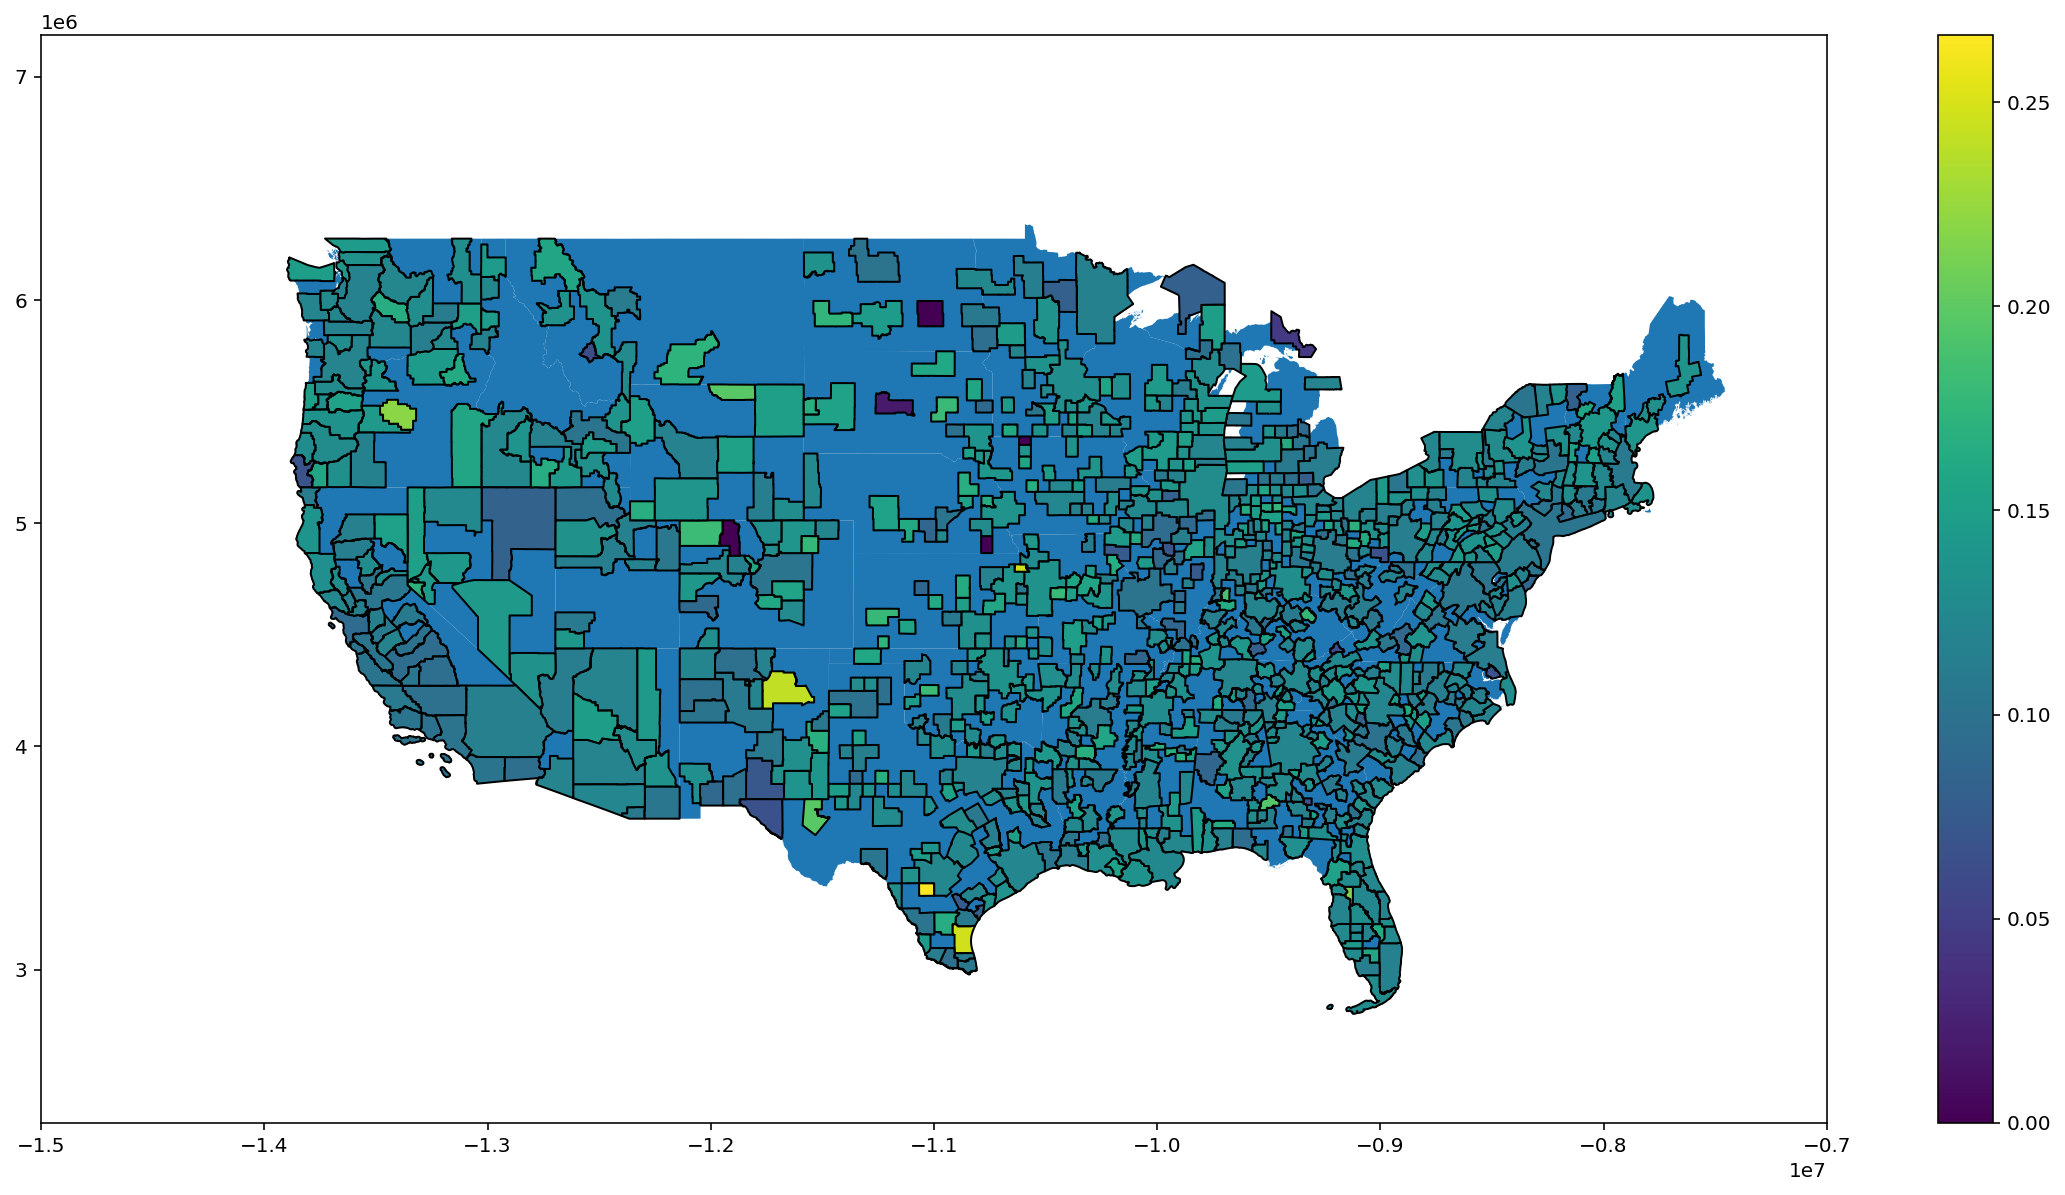

In [20]:
ax = plotUS()
byYear.loc[2021].plot(ax=ax, column='Less_High_pct', edgecolor="black", linewidth=1, legend=True);

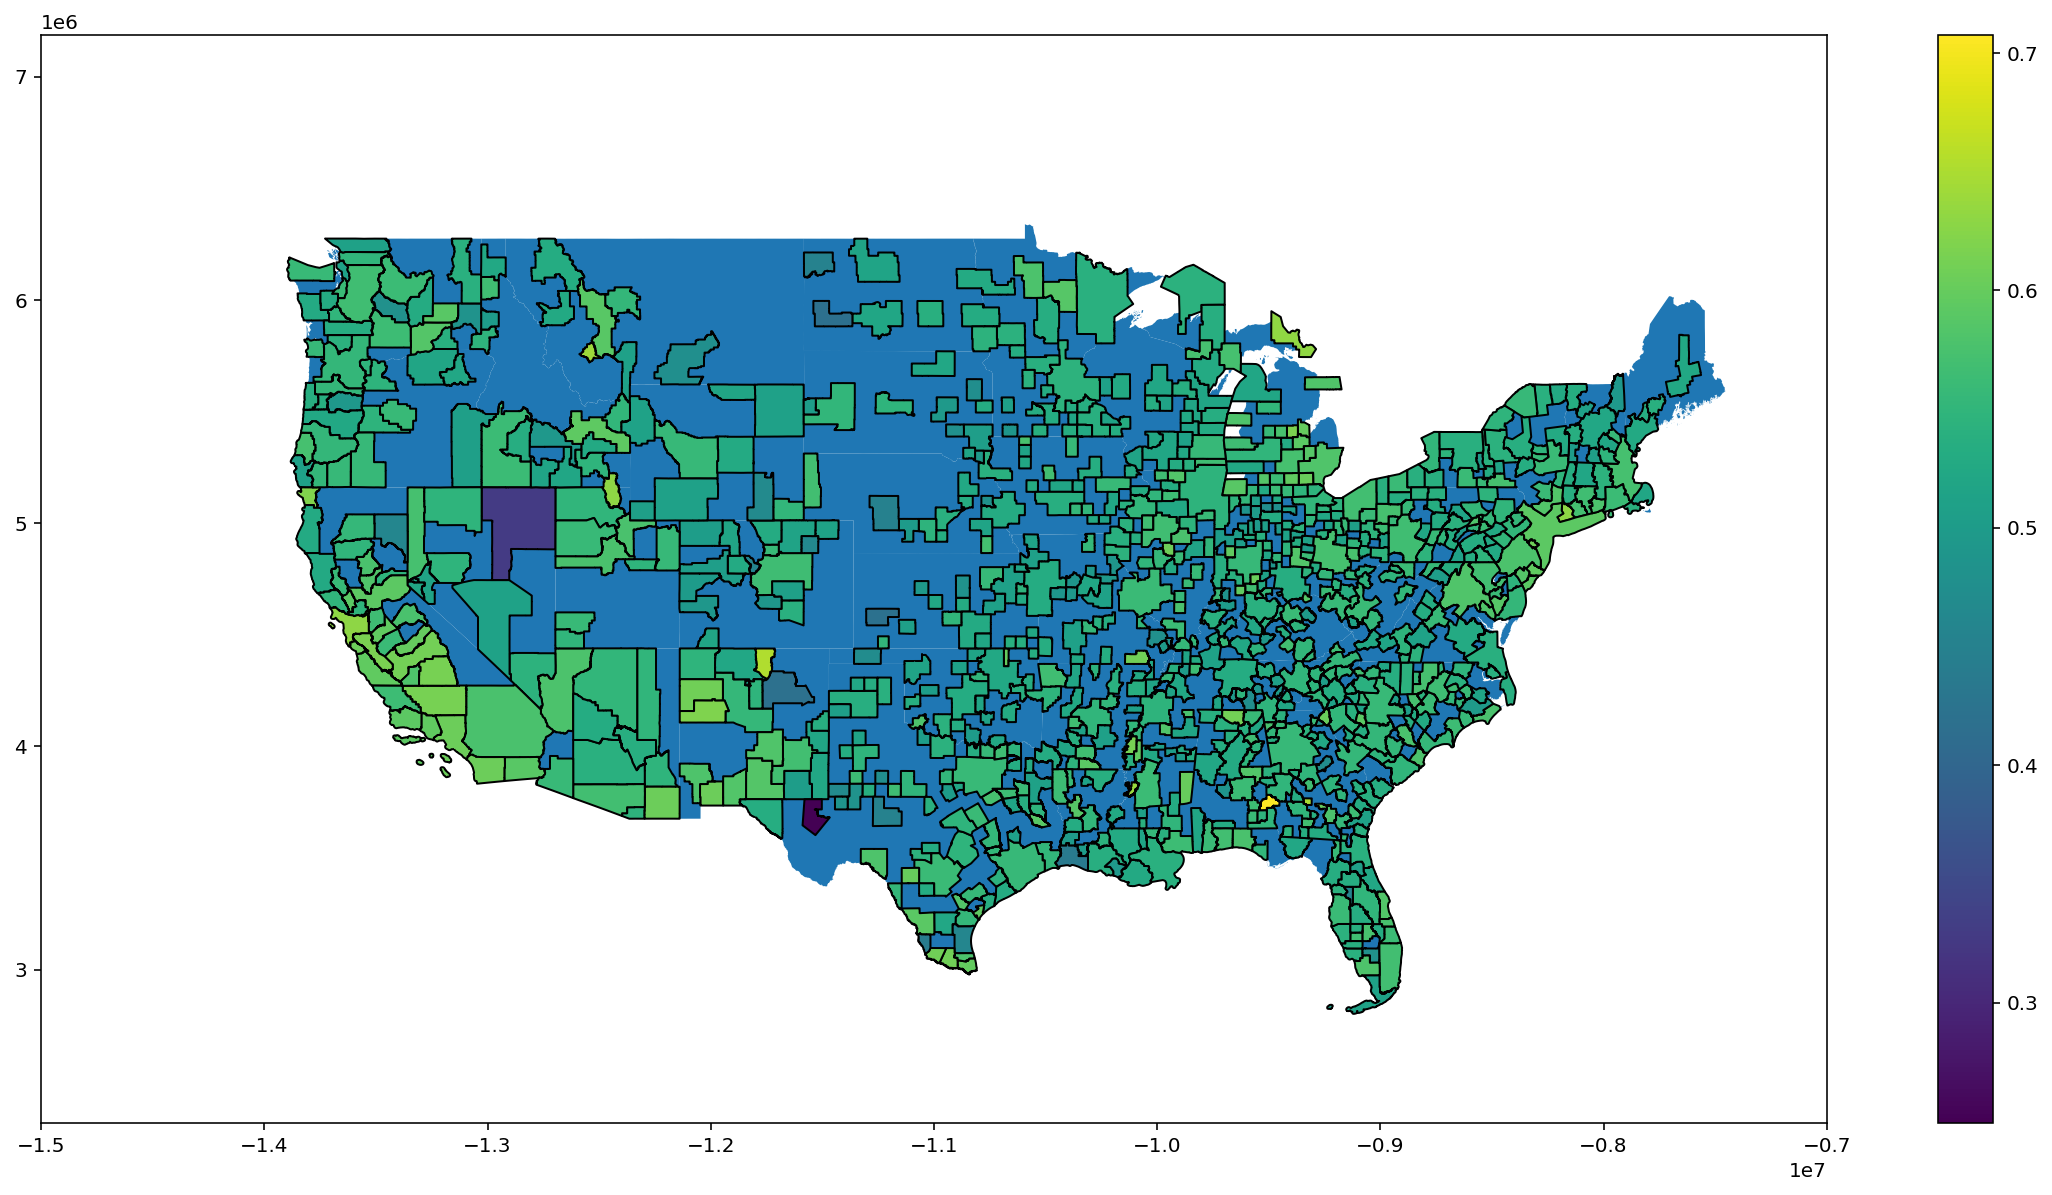

In [21]:
ax = plotUS()
byYear.loc[2020].plot(ax=ax, column='Bach_and_Above_pct', edgecolor="black", linewidth=1, legend=True);

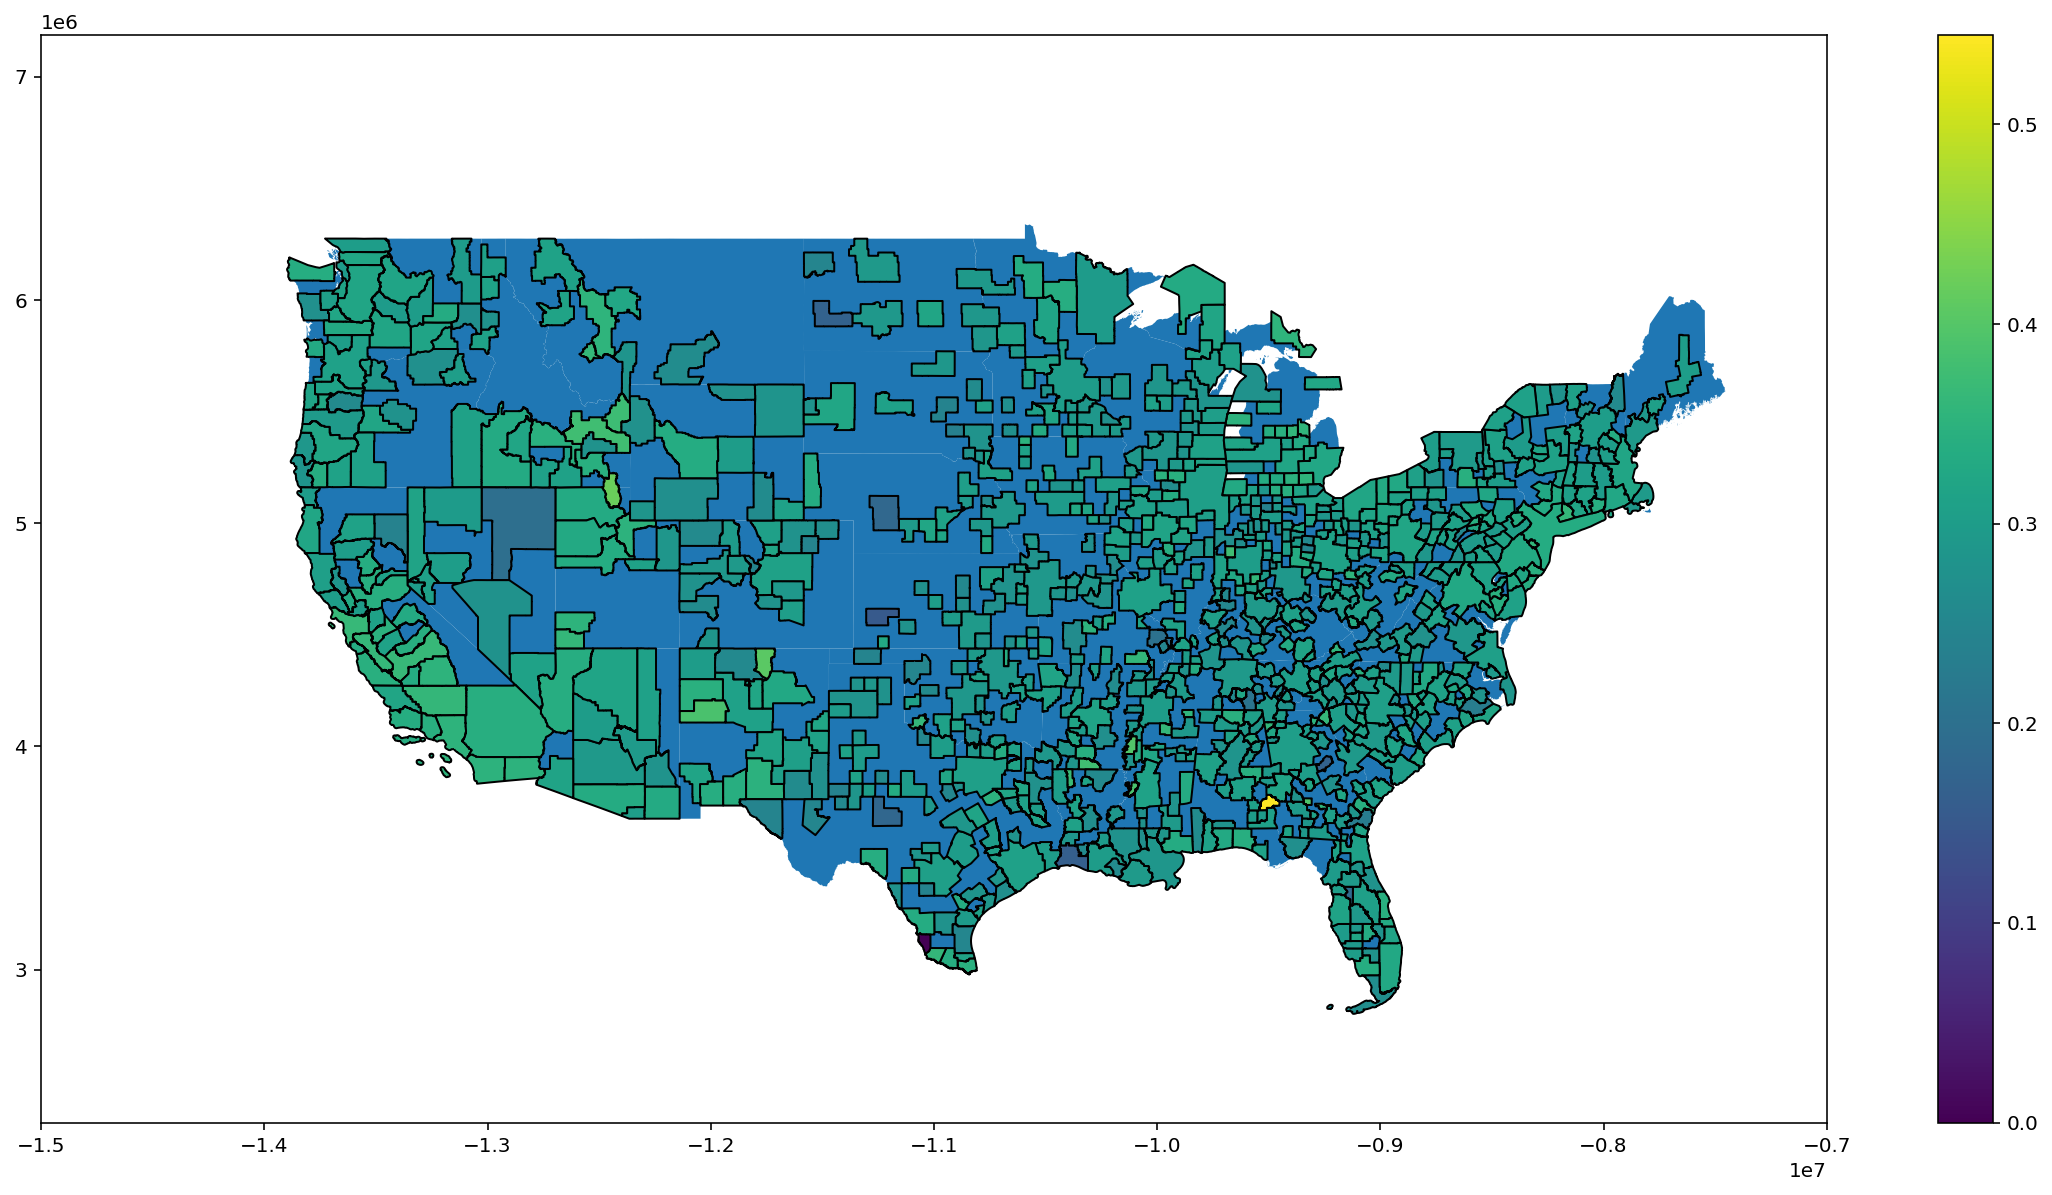

In [22]:
ax = plotUS()
byYear.loc[2020].plot(ax=ax, column='Grad_Prof_pct', edgecolor="black", linewidth=1, legend=True);

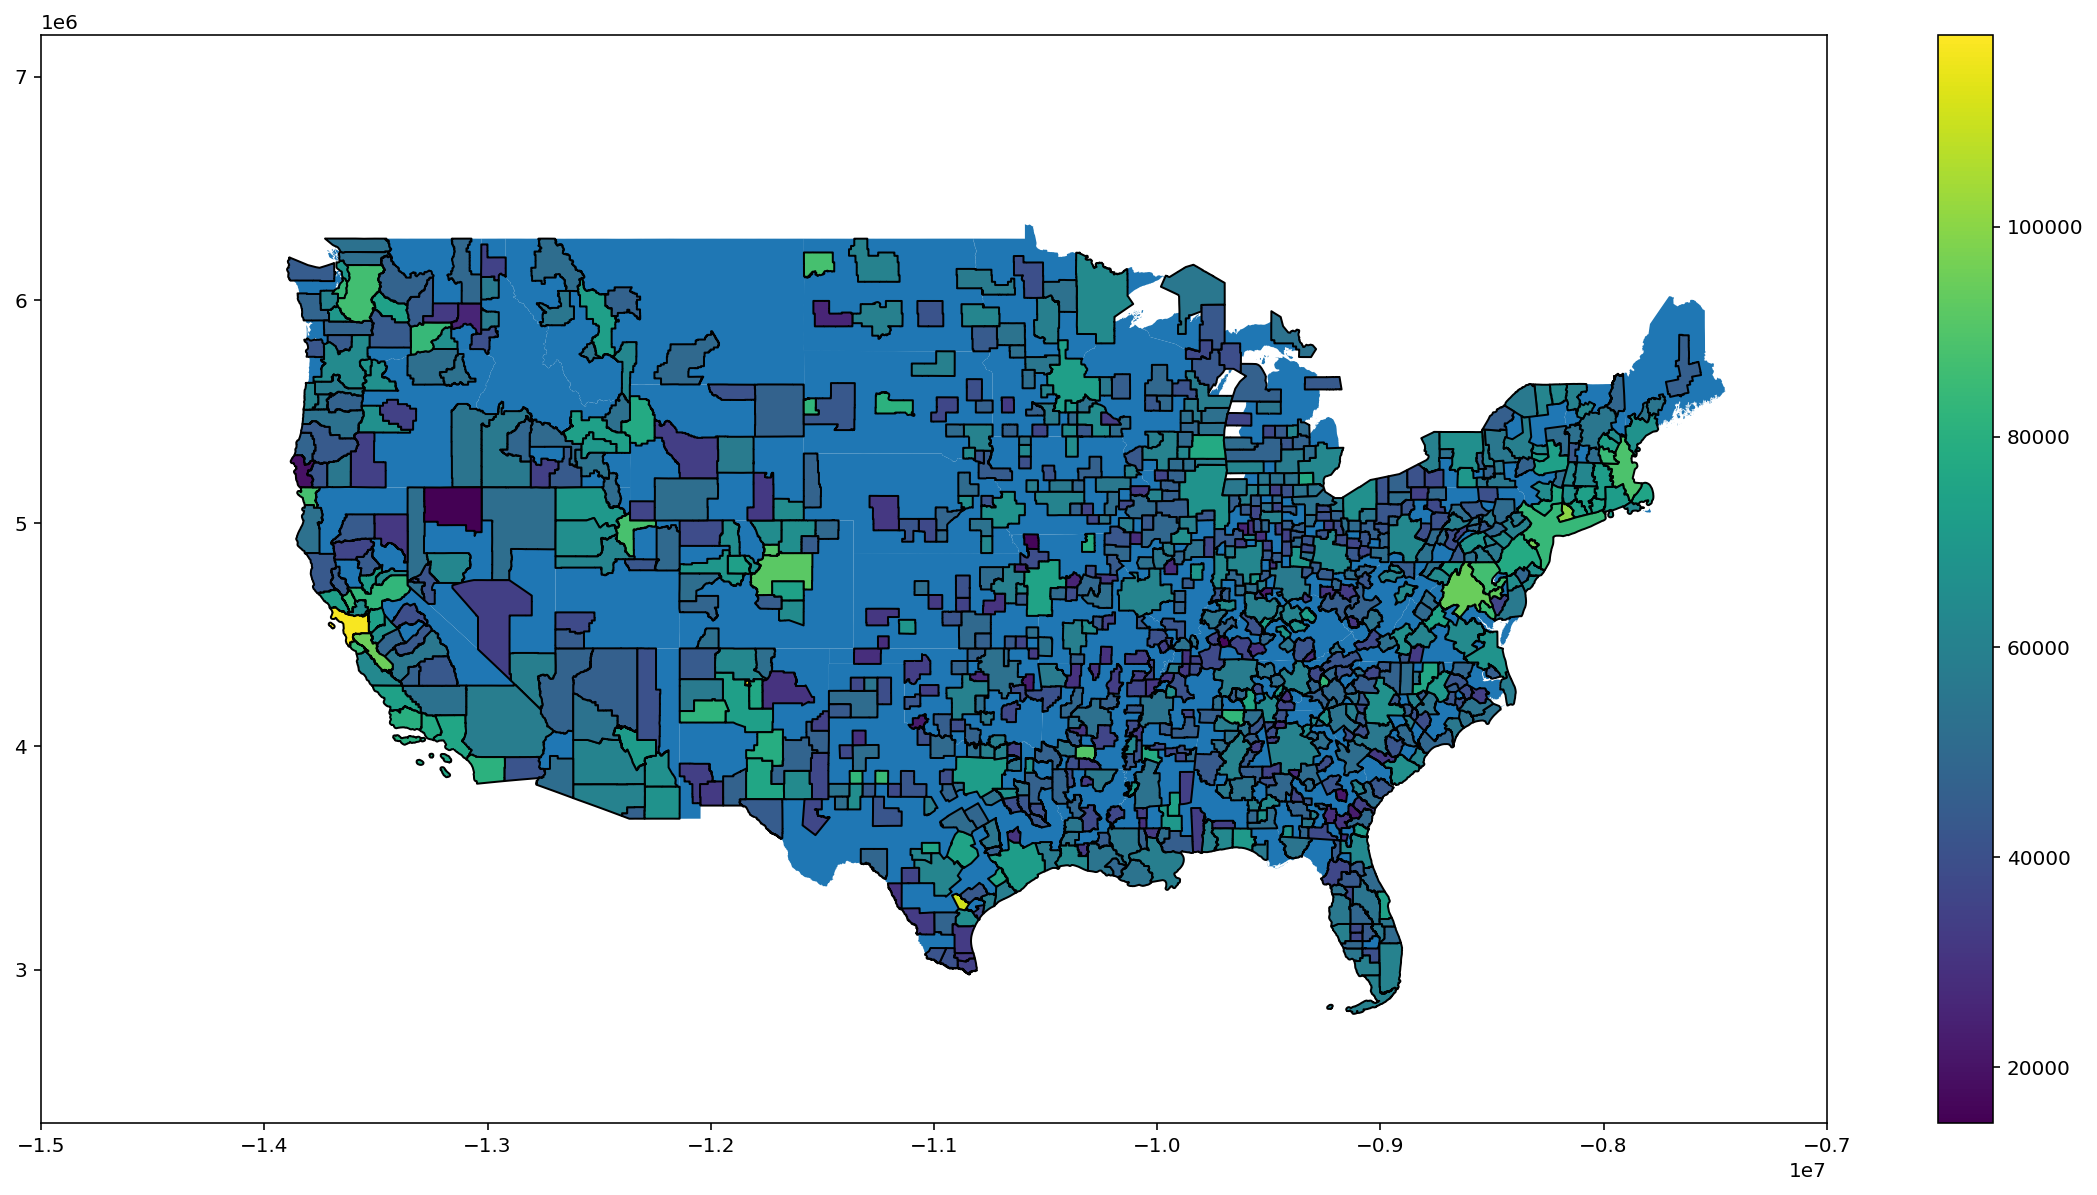

In [23]:
ax = plotUS()
byYear.loc[2021].plot(ax=ax, column='Prof_Sci_Tech', edgecolor="black", linewidth=1, legend=True);

In [24]:
merge['Prof_Sci_Tech'].mean()

48317.92293474491

In [25]:
merge.columns

Index(['CBSA', 'LSAD', 'POPESTIMATE2020', 'POPESTIMATE2021', 'POPESTIMATE2022',
       'NAME', 'geometry', 'metro', 'micro', 'buff', 'inBuff',
       'commuteBuffCount_19', 'workingPop_19', 'commutePercent_19',
       'commuteBuffCount_20', 'workingPop_20', 'commutePercent_20', 'liminal',
       'year', 'Total_Population', 'Total_Male_Pop', 'Total_Female_Pop',
       'Median_Age', 'M_Median_Age', 'F_Median_Age', 'Race_white',
       'Race_black', 'Race_Am_Indian', 'Race_Asian', 'Race_Pac_Isl',
       'Median_Income', 'Less_High', 'High_Equiv', 'College_Assoc_Equiv',
       'Bachelors', 'Grad_Prof', 'Ag_For_Fish_Hunt_Mine', 'Construction',
       'Manufacturing', 'Wholesale', 'Retail', 'Trans_Ware_Util',
       'Information', 'Fin_Insur_Real', 'Fin_Insur', 'Real_Rental',
       'Prof_Sci_Tech', 'Mngmt_Enter', 'Admin_WstMngmt', 'Ed_Servc',
       'Hlthcr_Social', 'Arts_Entr_Rec', 'Accom_Food_Srvc', 'Other_Servc',
       'Public_admin', 'Num_Total_Worker', 'Num_Comp_Info_Res', 'Num_Soft_D

In [26]:
#merge = merge[merge['liminal'] == True]

In [27]:
merge[(merge['metro'] == False) & (merge['liminal'] == False)]['Prof_Sci_Tech'].mean()

48672.393795186894

In [28]:
merge[merge['metro']]['Prof_Sci_Tech'].mean()

63935.43281880951

In [29]:
merge[merge['micro']]['Prof_Sci_Tech'].mean()

44901.944392523365

In [30]:
merge[merge['liminal']]['Prof_Sci_Tech'].mean()

44562.52157544165

In [31]:
merge[(merge['metro'] == False) & merge['liminal'] == False]['Sal_Avg_Occ'].mean()

44597.34953304095

In [32]:
merge[merge['metro']]['Avg_Comp_EngSci'].mean()

82475.22315783387

In [33]:
merge[merge['micro']]['Avg_Comp_EngSci'].mean()

65486.30255149813

In [34]:
merge[merge['liminal']]['Avg_Comp_EngSci'].mean()

66318.10860121633

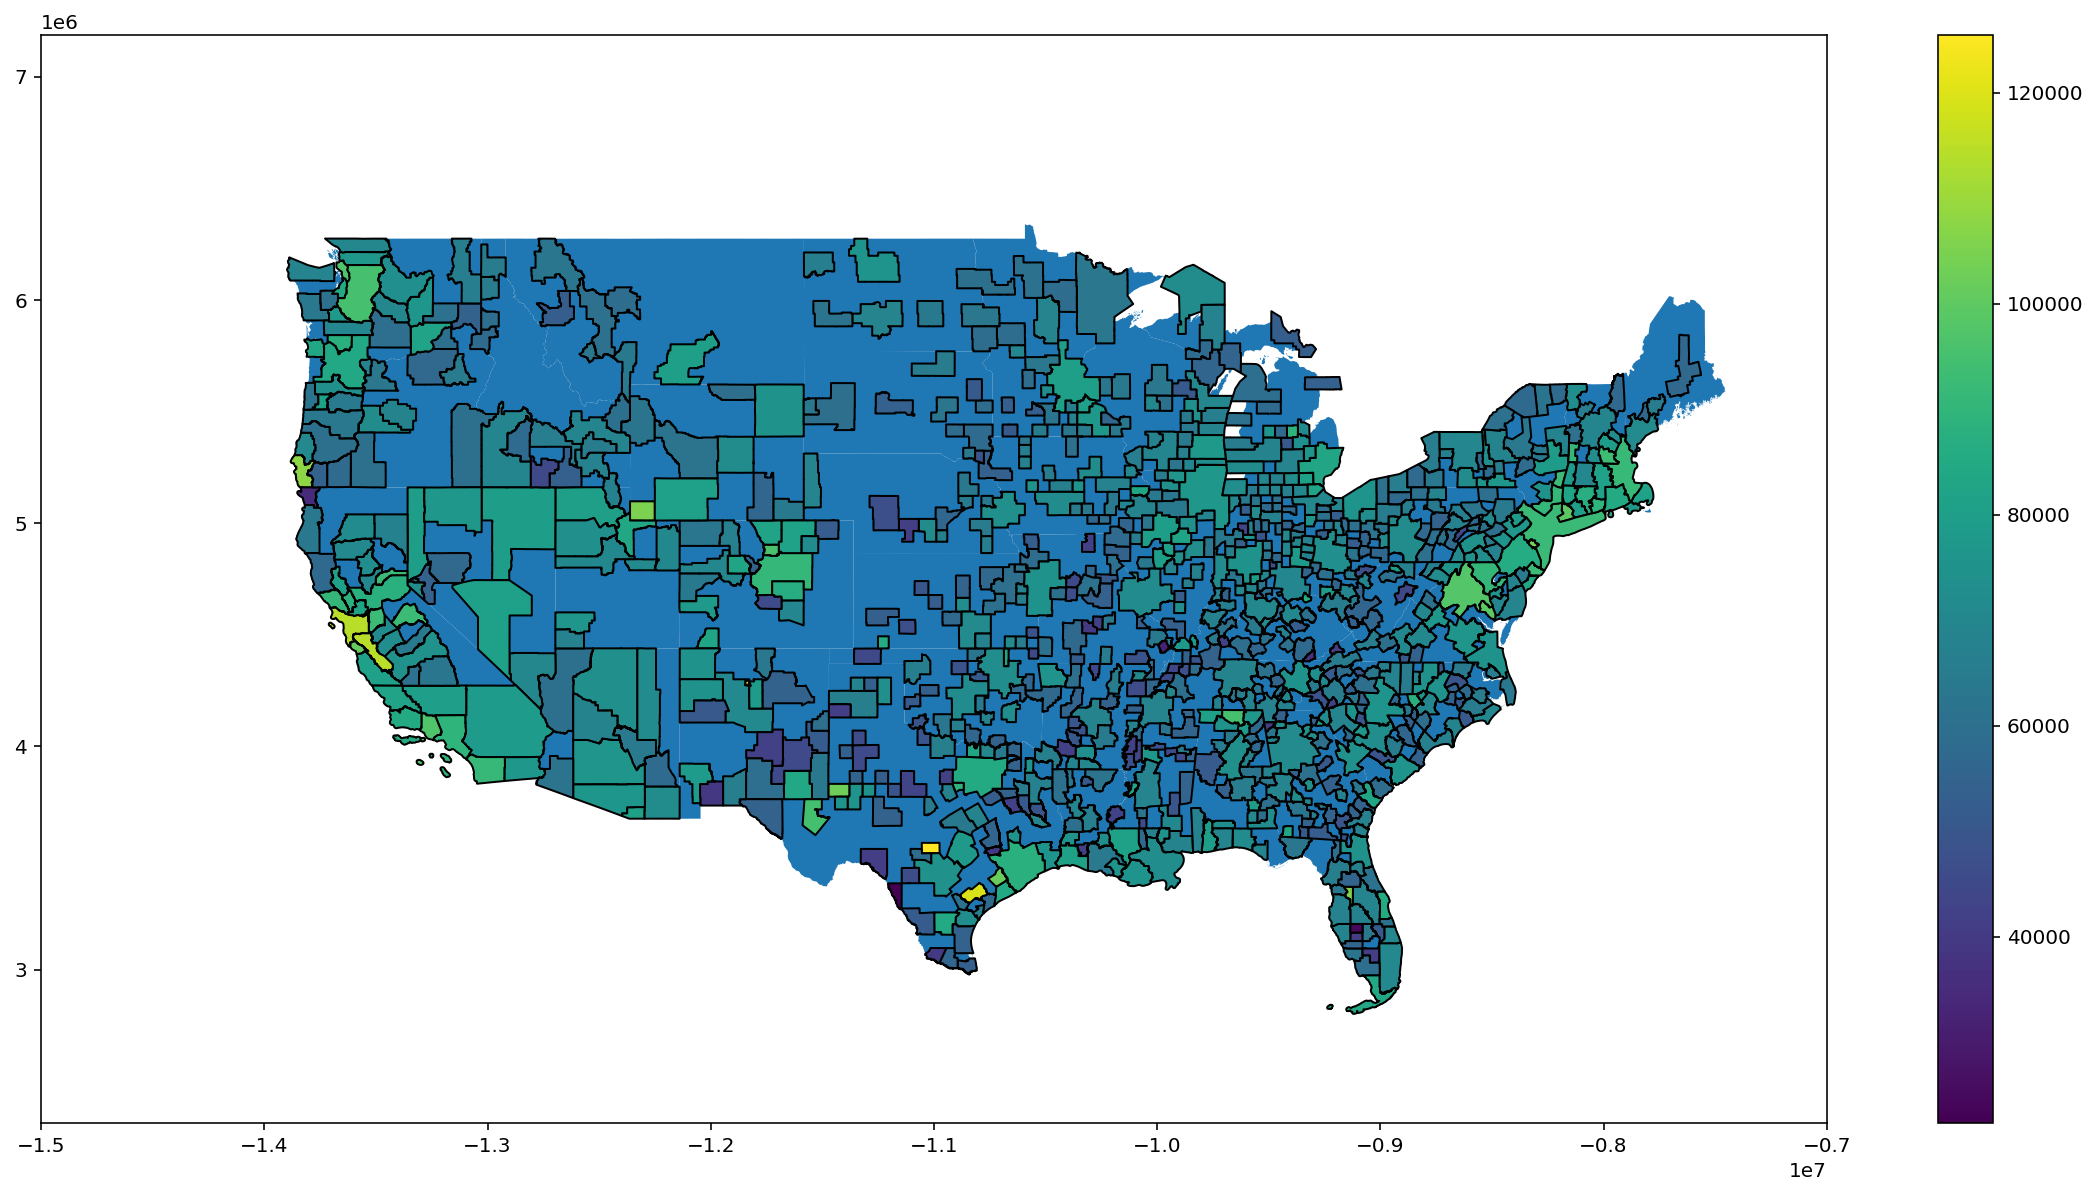

In [35]:
ax = plotUS()
byYear.loc[2018].plot(ax=ax, column='Avg_Comp_EngSci', edgecolor="black", linewidth=1, legend=True);

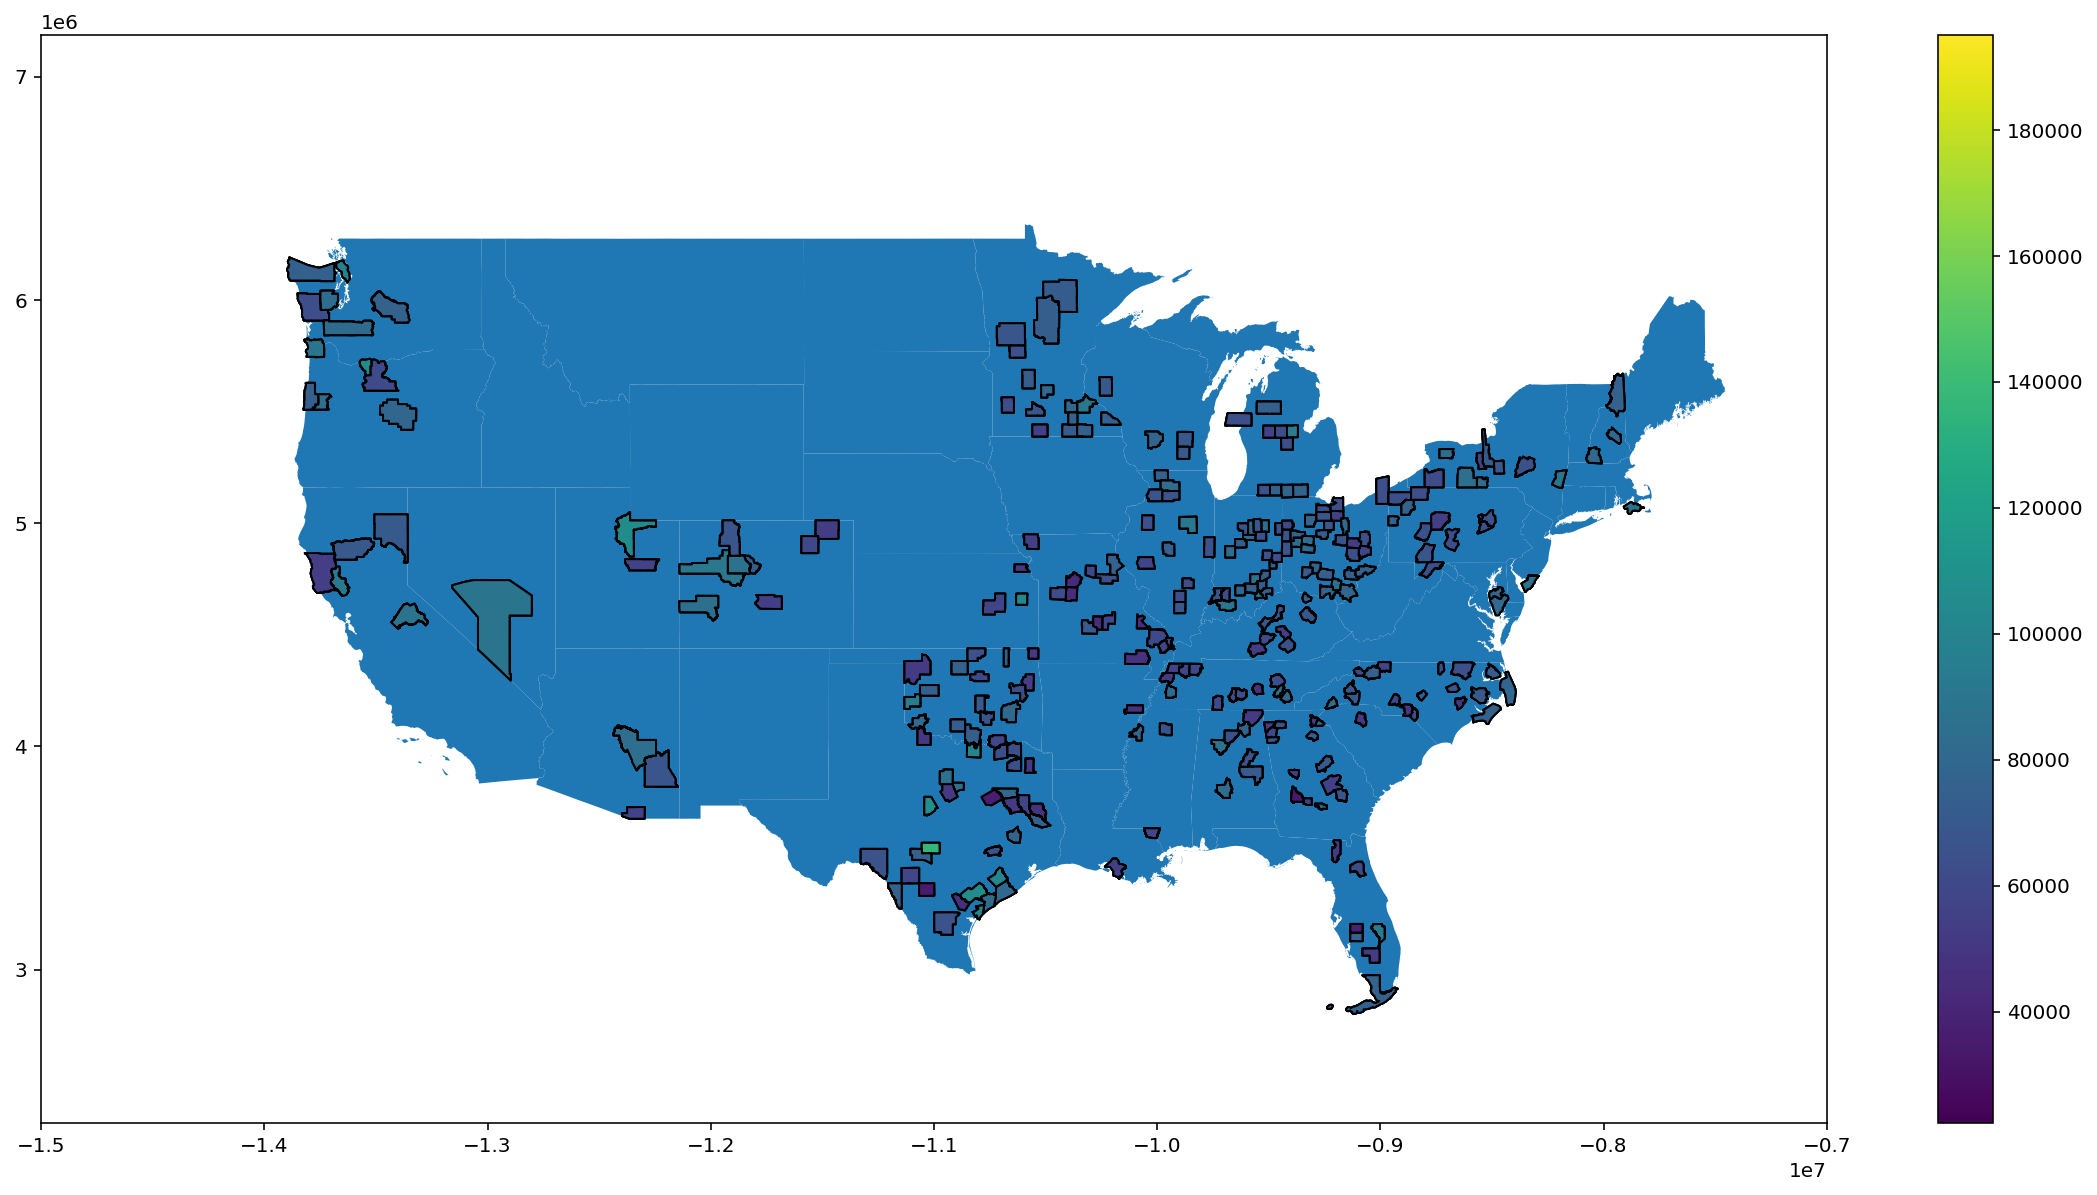

In [36]:
ax = plotUS()
merge[merge['liminal']].plot(ax=ax, column='Avg_Comp_EngSci', edgecolor="black", linewidth=1, legend=True);

In [37]:
merge[(merge['metro'] == False) & (merge['liminal'] == False)]['Avg_Mngmt_Bus_Fin'].mean()

61456.482550084926

In [38]:
merge[merge['metro']]['Avg_Mngmt_Bus_Fin'].mean()

75295.38789506491

In [39]:
merge[merge['micro']]['Avg_Mngmt_Bus_Fin'].mean()

58291.62614714574

In [40]:
merge[merge['liminal']]['Avg_Mngmt_Bus_Fin'].mean()

58685.26128472222